In [3]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


Metadata shape: (2985, 4)
Number of classes: 33
Number of authors: 106
Features shape: (2985, 1, 224, 313)
Labels shape: (2985,)
Authors shape: (2985,)
Unique classes: 33
Unique authors: 106
Successfully loaded 2985 out of 2985 spectrograms


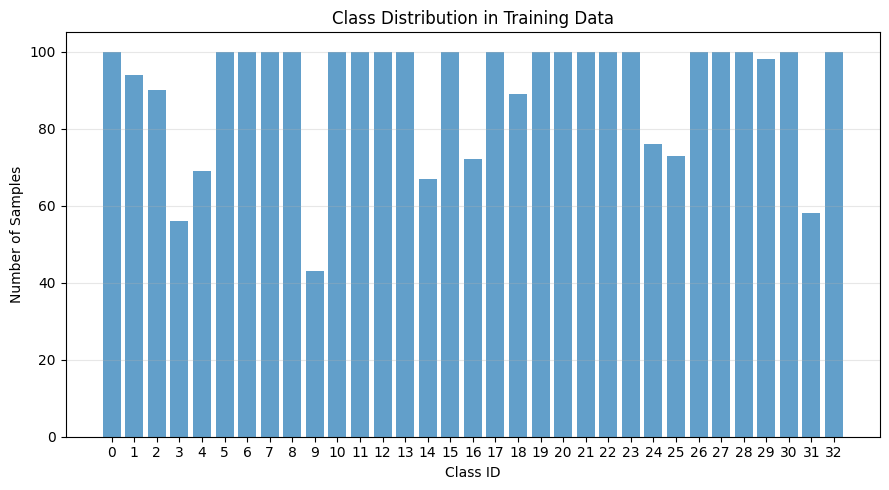

Average samples per class: 90.5


In [4]:
# New pipeline using .npy spectrograms from specs/ directory
specs_dir = os.path.join('..', 'database', 'specs')
specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

# Display class distribution
plt.figure(figsize=(9, 5))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [ ]:
# Find best seed
from utils.split import precompute_single_fold_split, precompute_kfold_splits, display_split_statistics

# Pre-compute single fold split (for most configurations)
single_fold_split = precompute_single_fold_split(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    max_attempts=400_000,
    min_test_segments=4)

print(f"Single Fold Split Type: {type(single_fold_split)}, Shape: {len(single_fold_split)}")

# Display statistics for verification
display_split_statistics(single_fold_split, "single")

In [ ]:
# # Split with a set seed
# from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
# seed_single = 245323 # Quality: 0.2671
# seed_kfold = 11052 # Quality: 0.3332

# single_fold_split = get_set_seed_indices(
#     features=features,
#     labels=labels, 
#     authors=authors,
#     test_size=0.2,
#     seed=seed_single)

# kfold_splits = get_set_seed_kfold_indices(
#     features=features,
#     labels=labels,
#     authors=authors,
#     n_splits=4,
#     seed=seed_kfold)

# display_split_statistics(single_fold_split, "single")
# display_split_statistics(kfold_splits, "kfold")


📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2328
Validation samples: 657
Split ratio: 77.99% - 22.01%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3332
  Fold 1: 2170 train, 815 val (72.70% - 27.30%)
  Fold 2: 2319 train, 666 val (77.69% - 22.31%)
  Fold 3: 2312 train, 673 val (77.45% - 22.55%)
  Fold 4: 2154 train, 831 val (72.16% - 27.84%)
----------------------------------------


In [6]:
# Import all models and training utilities
from utils.final_models import (
    BirdCNN_v5, BirdCNN_v5b, BirdCNN_v5c, BirdCNN_v5d, BirdCNN_v7, BirdCNN_v7b, BirdCNN_v7c, BirdCNN_v7d, BirdCNN_v7e
)
from utils.training_core import single_fold_training
from utils.metrics import plot_metrics

# Define all 16 model architectures for testing
model_architectures = {
    'BirdCNN_v5': BirdCNN_v5,
    'BirdCNN_v5b': BirdCNN_v5b,
    'BirdCNN_v5c': BirdCNN_v5c,
    'BirdCNN_v5d': BirdCNN_v5d,
    'BirdCNN_v7': BirdCNN_v7,
    'BirdCNN_v7b': BirdCNN_v7b,
    'BirdCNN_v7c': BirdCNN_v7c,
    'BirdCNN_v7d': BirdCNN_v7d,
    'BirdCNN_v7e': BirdCNN_v7e,
}

# Initialize results database for all model-config combinations
building_results = {}
class_num = len(np.unique(labels))

In [7]:
# Config
configurations = {
    'configA': {
            'name': 'Chaos Candidate',
            'use_adam': True,
            'estop_thresh': 37,
            'batch_size': 45,
            'use_class_weights': True,
            'l2_regularization': 3.7e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 73},
            'initial_lr': 0.00137,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.73,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configB': {
            'name': 'Higher Learning Rate',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 48,
            'use_class_weights': True,
            'l2_regularization': 4.2e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 68},
            'initial_lr': 0.00165,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.68,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configC': {
            'name': 'Lower Regularization',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 42,
            'use_class_weights': True,
            'l2_regularization': 2.8e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 78},
            'initial_lr': 0.00121,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.81,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'configD': {
            'name': 'Larger Batch Size',
            'use_adam': True,
            'estop_thresh': 45,
            'batch_size': 56,
            'use_class_weights': True,
            'l2_regularization': 3.3e-4,
            'lr_schedule': {'type': 'cosine', 'T_max': 65},
            'initial_lr': 0.00149,
            'standardize': False,
            'spec_augment': True,
            'noise_augment': False,
            'num_epochs': 320,
            'mixed_precision': ENABLE_OPTIMIZATIONS,
            'gradient_clipping': 0.65,
            'parallel_folds': ENABLE_PARALLEL_FOLDS,
            'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
}

In [ ]:
# === CONFIG A TRAINING: Parameters Frankenstein ===
print("="*80)

config_a = configurations['configA']
config_a_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config A")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_a,
            spec_augment=config_a['spec_augment'],
            gaussian_noise=config_a['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config A"  # Pass config_id for progress bar
        )
        
        # Store result
        config_a_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configA'
        }
        
        # Store in global results
        building_results[f"{model_name}_configA"] = config_a_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_a_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_a_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configA'
        }
        building_results[f"{model_name}_configA"] = config_a_results[model_name]

print(f"\n{'='*60}")
print("CONFIG A TRAINING COMPLETED")
successful_a = sum(1 for result in config_a_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_a}/{len(model_architectures)}")
print(f"{'='*60}")

In [ ]:
# === CONFIG B TRAINING: Balanced Classes Focus ===
print("="*80)

config_b = configurations['configB']
config_b_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config B")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_b,
            spec_augment=config_b['spec_augment'],
            gaussian_noise=config_b['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config B"  # Pass config_id for progress bar
        )
        
        # Store result
        config_b_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configB'
        }
        
        # Store in global results
        building_results[f"{model_name}_configB"] = config_b_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_b_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_b_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configB'
        }
        building_results[f"{model_name}_configB"] = config_b_results[model_name]

print(f"\n{'='*60}")
print("CONFIG B TRAINING COMPLETED")
successful_b = sum(1 for result in config_b_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_b}/{len(model_architectures)}")
print(f"{'='*60}")

STARTING CONFIG B: Balanced Classes Focus

Training BirdCNN_v5 with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.1627 | TrAcc: 0.9670 | ValLoss: 1.8564 | ValAcc: 0.5192:  43%|████▎     | 139/320 [04:56<06:25,  2.13s/it]


Early stopped after 139 epochs (best at epoch 95)
Best - Val Acc: 0.5689, Val F1: 0.5556
✅ BirdCNN_v5 completed successfully!
   Best Val Acc: 0.5689
   Best Val F1: 0.5556
   Training time: 298.6s

Training BirdCNN_v5b with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.1743 | TrAcc: 0.9627 | ValLoss: 1.9321 | ValAcc: 0.5449:  38%|███▊      | 122/320 [03:39<05:55,  1.80s/it]


Early stopped after 122 epochs (best at epoch 78)
Best - Val Acc: 0.5913, Val F1: 0.5632
✅ BirdCNN_v5b completed successfully!
   Best Val Acc: 0.5913
   Best Val F1: 0.5632
   Training time: 221.5s

Training BirdCNN_v5c with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.0271 | TrAcc: 0.9970 | ValLoss: 1.9354 | ValAcc: 0.5561:  27%|██▋       | 85/320 [04:50<13:24,  3.42s/it] 


Early stopped after 85 epochs (best at epoch 41)
Best - Val Acc: 0.5705, Val F1: 0.5521
✅ BirdCNN_v5c completed successfully!
   Best Val Acc: 0.5705
   Best Val F1: 0.5521
   Training time: 293.4s

Training BirdCNN_v5d with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.0331 | TrAcc: 0.9952 | ValLoss: 2.0056 | ValAcc: 0.5561:  28%|██▊       | 88/320 [02:49<07:26,  1.92s/it]


Early stopped after 88 epochs (best at epoch 44)
Best - Val Acc: 0.6154, Val F1: 0.5867
✅ BirdCNN_v5d completed successfully!
   Best Val Acc: 0.6154
   Best Val F1: 0.5867
   Training time: 171.4s

Training BirdCNN_v7 with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.2709 | TrAcc: 0.9332 | ValLoss: 2.6055 | ValAcc: 0.3894:  35%|███▌      | 112/320 [09:29<17:37,  5.08s/it]


Early stopped after 112 epochs (best at epoch 68)
Best - Val Acc: 0.6330, Val F1: 0.6017
✅ BirdCNN_v7 completed successfully!
   Best Val Acc: 0.6330
   Best Val F1: 0.6017
   Training time: 572.7s

Training BirdCNN_v7b with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.1857 | TrAcc: 0.9549 | ValLoss: 2.3228 | ValAcc: 0.4696:  32%|███▎      | 104/320 [05:02<10:27,  2.90s/it]


Early stopped after 104 epochs (best at epoch 60)
Best - Val Acc: 0.6250, Val F1: 0.6180
✅ BirdCNN_v7b completed successfully!
   Best Val Acc: 0.6250
   Best Val F1: 0.6180
   Training time: 304.5s

Training BirdCNN_v7c with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.2730 | TrAcc: 0.9314 | ValLoss: 2.5666 | ValAcc: 0.3942:  35%|███▌      | 113/320 [17:38<32:18,  9.36s/it]


Early stopped after 113 epochs (best at epoch 69)
Best - Val Acc: 0.6106, Val F1: 0.5977
✅ BirdCNN_v7c completed successfully!
   Best Val Acc: 0.6106
   Best Val F1: 0.5977
   Training time: 1062.6s

Training BirdCNN_v7d with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.2265 | TrAcc: 0.9401 | ValLoss: 2.6949 | ValAcc: 0.4054:  39%|███▉      | 125/320 [08:48<13:44,  4.23s/it]


Early stopped after 125 epochs (best at epoch 81)
Best - Val Acc: 0.6330, Val F1: 0.6038
✅ BirdCNN_v7d completed successfully!
   Best Val Acc: 0.6330
   Best Val F1: 0.6038
   Training time: 531.4s

Training BirdCNN_v7e with Config B
Train size: 2328, Val size: 657


Config: Config B | TrLoss: 0.2509 | TrAcc: 0.9306 | ValLoss: 2.5212 | ValAcc: 0.4263:  39%|███▉      | 126/320 [15:52<24:26,  7.56s/it]


Early stopped after 126 epochs (best at epoch 82)
Best - Val Acc: 0.6410, Val F1: 0.6167
✅ BirdCNN_v7e completed successfully!
   Best Val Acc: 0.6410
   Best Val F1: 0.6167
   Training time: 956.3s

CONFIG B TRAINING COMPLETED
Successful models: 9/9


In [ ]:
# === CONFIG C TRAINING: Chaos Theory ===
print("="*80)

config_c = configurations['configC']
config_c_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config C")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_c,
            spec_augment=config_c['spec_augment'],
            gaussian_noise=config_c['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config C"  # Pass config_id for progress bar
        )
        
        # Store result
        config_c_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configC'
        }
        
        # Store in global results
        building_results[f"{model_name}_configC"] = config_c_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_c_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_c_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configC'
        }
        building_results[f"{model_name}_configC"] = config_c_results[model_name]

print(f"\n{'='*60}")
print("CONFIG C TRAINING COMPLETED")
successful_c = sum(1 for result in config_c_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_c}/{len(model_architectures)}")
print(f"{'='*60}")

STARTING CONFIG C: Chaos Theory

Training BirdCNN_v5 with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0200 | TrAcc: 0.9957 | ValLoss: 1.7291 | ValAcc: 0.6000:  17%|█▋        | 55/320 [02:06<10:09,  2.30s/it]


Early stopped after 55 epochs (best at epoch 11)
Best - Val Acc: 0.5937, Val F1: 0.5755
✅ BirdCNN_v5 completed successfully!
   Best Val Acc: 0.5937
   Best Val F1: 0.5755
   Training time: 128.7s

Training BirdCNN_v5b with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0153 | TrAcc: 0.9987 | ValLoss: 1.7163 | ValAcc: 0.6111:  29%|██▉       | 92/320 [02:52<07:08,  1.88s/it]


Early stopped after 92 epochs (best at epoch 48)
Best - Val Acc: 0.6270, Val F1: 0.6121
✅ BirdCNN_v5b completed successfully!
   Best Val Acc: 0.6270
   Best Val F1: 0.6121
   Training time: 174.9s

Training BirdCNN_v5c with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.1111 | TrAcc: 0.9766 | ValLoss: 2.0433 | ValAcc: 0.5603:  44%|████▍     | 141/320 [07:38<09:41,  3.25s/it]


Early stopped after 141 epochs (best at epoch 97)
Best - Val Acc: 0.6476, Val F1: 0.6366
✅ BirdCNN_v5c completed successfully!
   Best Val Acc: 0.6476
   Best Val F1: 0.6366
   Training time: 460.7s

Training BirdCNN_v5d with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0095 | TrAcc: 0.9996 | ValLoss: 1.8343 | ValAcc: 0.6079:  20%|██        | 65/320 [02:08<08:24,  1.98s/it]


Early stopped after 65 epochs (best at epoch 21)
Best - Val Acc: 0.5556, Val F1: 0.5408
✅ BirdCNN_v5d completed successfully!
   Best Val Acc: 0.5556
   Best Val F1: 0.5408
   Training time: 130.6s

Training BirdCNN_v7 with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.1167 | TrAcc: 0.9697 | ValLoss: 2.2801 | ValAcc: 0.4683:  38%|███▊      | 121/320 [10:30<17:17,  5.21s/it]


Early stopped after 121 epochs (best at epoch 77)
Best - Val Acc: 0.6063, Val F1: 0.5853
✅ BirdCNN_v7 completed successfully!
   Best Val Acc: 0.6063
   Best Val F1: 0.5853
   Training time: 634.0s

Training BirdCNN_v7b with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0931 | TrAcc: 0.9753 | ValLoss: 2.6899 | ValAcc: 0.4492:  35%|███▍      | 111/320 [05:41<10:42,  3.07s/it]


Early stopped after 111 epochs (best at epoch 67)
Best - Val Acc: 0.6317, Val F1: 0.6140
✅ BirdCNN_v7b completed successfully!
   Best Val Acc: 0.6317
   Best Val F1: 0.6140
   Training time: 343.9s

Training BirdCNN_v7c with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0419 | TrAcc: 0.9926 | ValLoss: 2.1826 | ValAcc: 0.5873:  30%|███       | 96/320 [15:18<35:44,  9.57s/it] 


Early stopped after 96 epochs (best at epoch 52)
Best - Val Acc: 0.5952, Val F1: 0.5858
✅ BirdCNN_v7c completed successfully!
   Best Val Acc: 0.5952
   Best Val F1: 0.5858
   Training time: 923.3s

Training BirdCNN_v7d with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.1067 | TrAcc: 0.9723 | ValLoss: 2.2845 | ValAcc: 0.5476:  38%|███▊      | 122/320 [08:48<14:17,  4.33s/it]


Early stopped after 122 epochs (best at epoch 78)
Best - Val Acc: 0.6365, Val F1: 0.6119
✅ BirdCNN_v7d completed successfully!
   Best Val Acc: 0.6365
   Best Val F1: 0.6119
   Training time: 531.3s

Training BirdCNN_v7e with Config C
Train size: 2328, Val size: 657


Config: Config C | TrLoss: 0.0110 | TrAcc: 0.9987 | ValLoss: 1.9034 | ValAcc: 0.5984:  27%|██▋       | 86/320 [11:08<30:18,  7.77s/it] 


Early stopped after 86 epochs (best at epoch 42)
Best - Val Acc: 0.6175, Val F1: 0.5833
✅ BirdCNN_v7e completed successfully!
   Best Val Acc: 0.6175
   Best Val F1: 0.5833
   Training time: 672.2s

CONFIG C TRAINING COMPLETED
Successful models: 9/9


In [ ]:
# === CONFIG D TRAINING: Balanced Classes AdamW ===
print("="*80)

config_d = configurations['configD']
config_d_results = {}

for model_name, model_class in model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config D")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_d,
            spec_augment=config_d['spec_augment'],
            gaussian_noise=config_d['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config D"  # Pass config_id for progress bar
        )
        
        # Store result
        config_d_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configD'
        }
        
        # Store in global results
        building_results[f"{model_name}_configD"] = config_d_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_d_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_d_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configD'
        }
        building_results[f"{model_name}_configD"] = config_d_results[model_name]

print(f"\n{'='*60}")
print("CONFIG D TRAINING COMPLETED")
successful_d = sum(1 for result in config_d_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_d}/{len(model_architectures)}")
print(f"{'='*60}")

STARTING CONFIG D: Balanced Classes AdamW

Training BirdCNN_v5 with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.0645 | TrAcc: 0.9900 | ValLoss: 1.5668 | ValAcc: 0.6234:  72%|███████▎  | 232/320 [08:10<03:06,  2.12s/it]


Early stopped after 232 epochs (best at epoch 188)
Best - Val Acc: 0.6818, Val F1: 0.6595
✅ BirdCNN_v5 completed successfully!
   Best Val Acc: 0.6818
   Best Val F1: 0.6595
   Training time: 492.9s

Training BirdCNN_v5b with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.1510 | TrAcc: 0.9656 | ValLoss: 2.1675 | ValAcc: 0.5097:  38%|███▊      | 122/320 [03:38<05:55,  1.79s/it]


Early stopped after 122 epochs (best at epoch 78)
Best - Val Acc: 0.5909, Val F1: 0.5698
✅ BirdCNN_v5b completed successfully!
   Best Val Acc: 0.5909
   Best Val F1: 0.5698
   Training time: 221.1s

Training BirdCNN_v5c with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.0549 | TrAcc: 0.9926 | ValLoss: 2.0213 | ValAcc: 0.5325:  29%|██▉       | 93/320 [05:06<12:28,  3.30s/it]


Early stopped after 93 epochs (best at epoch 49)
Best - Val Acc: 0.5877, Val F1: 0.5658
✅ BirdCNN_v5c completed successfully!
   Best Val Acc: 0.5877
   Best Val F1: 0.5658
   Training time: 309.1s

Training BirdCNN_v5d with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.0608 | TrAcc: 0.9891 | ValLoss: 2.0109 | ValAcc: 0.5471:  30%|██▉       | 95/320 [03:05<07:19,  1.95s/it]


Early stopped after 95 epochs (best at epoch 51)
Best - Val Acc: 0.6153, Val F1: 0.5794
✅ BirdCNN_v5d completed successfully!
   Best Val Acc: 0.6153
   Best Val F1: 0.5794
   Training time: 187.6s

Training BirdCNN_v7 with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.2547 | TrAcc: 0.9338 | ValLoss: 2.4448 | ValAcc: 0.4821:  37%|███▋      | 118/320 [17:12<29:28,  8.75s/it]


Early stopped after 118 epochs (best at epoch 74)
Best - Val Acc: 0.6380, Val F1: 0.6134
✅ BirdCNN_v7 completed successfully!
   Best Val Acc: 0.6380
   Best Val F1: 0.6134
   Training time: 1036.3s

Training BirdCNN_v7b with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.1793 | TrAcc: 0.9551 | ValLoss: 1.8796 | ValAcc: 0.5373:  37%|███▋      | 118/320 [11:38<19:55,  5.92s/it]


Early stopped after 118 epochs (best at epoch 74)
Best - Val Acc: 0.6266, Val F1: 0.5849
✅ BirdCNN_v7b completed successfully!
   Best Val Acc: 0.6266
   Best Val F1: 0.5849
   Training time: 703.2s

Training BirdCNN_v7c with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 1.0877 | TrAcc: 0.6860 | ValLoss: 2.8605 | ValAcc: 0.3880:   7%|▋         | 22/320 [24:15<5:28:38, 66.17s/it]


KeyboardInterrupt: 

In [8]:
# error de memoria, me faltaron correr 3
last_model_architectures = {
    'BirdCNN_v7d': BirdCNN_v7d,
    'BirdCNN_v7e': BirdCNN_v7e,
}

print("="*80)

config_d = configurations['configD']
config_d_results = {}

for model_name, model_class in last_model_architectures.items():
    try:
        print(f"\n{'='*50}")
        print(f"Training {model_name} with Config D")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        # Create model instance
        model = model_class(num_classes=class_num)
        
        # Run single fold training
        result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=model_class,
            num_classes=class_num,
            config=config_d,
            spec_augment=config_d['spec_augment'],
            gaussian_noise=config_d['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id="Config D"  # Pass config_id for progress bar
        )
        
        # Store result
        config_d_results[model_name] = {
            'status': 'success',
            'result': result,
            'training_time': time.time() - start_time,
            'config': 'configD'
        }
        
        # Store in global results
        building_results[f"{model_name}_configD"] = config_d_results[model_name]
        
        print(f"✅ {model_name} completed successfully!")
        print(f"   Best Val Acc: {result.get('best_val_acc', 0):.4f}")
        print(f"   Best Val F1: {result.get('best_val_f1', 0):.4f}")
        print(f"   Training time: {config_d_results[model_name]['training_time']:.1f}s")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        config_d_results[model_name] = {
            'status': 'failed',
            'error': str(e),
            'config': 'configD'
        }
        building_results[f"{model_name}_configD"] = config_d_results[model_name]

print(f"\n{'='*60}")
print("CONFIG D TRAINING COMPLETED")
successful_d = sum(1 for result in config_d_results.values() if result['status'] == 'success')
print(f"Successful models: {successful_d}/{len(last_model_architectures)}")
print(f"{'='*60}")


Training BirdCNN_v7d with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.1553 | TrAcc: 0.9604 | ValLoss: 2.4845 | ValAcc: 0.4432:  30%|██▉       | 95/320 [06:46<16:01,  4.27s/it]


Early stopped after 95 epochs (best at epoch 51)
Best - Val Acc: 0.6266, Val F1: 0.6006
✅ BirdCNN_v7d completed successfully!
   Best Val Acc: 0.6266
   Best Val F1: 0.6006
   Training time: 408.7s

Training BirdCNN_v7e with Config D
Train size: 2328, Val size: 657


Config: Config D | TrLoss: 0.2463 | TrAcc: 0.9368 | ValLoss: 2.6806 | ValAcc: 0.4529:  33%|███▎      | 105/320 [13:26<27:30,  7.68s/it] 


Early stopped after 105 epochs (best at epoch 61)
Best - Val Acc: 0.6461, Val F1: 0.6235
✅ BirdCNN_v7e completed successfully!
   Best Val Acc: 0.6461
   Best Val F1: 0.6235
   Training time: 810.0s

CONFIG D TRAINING COMPLETED
Successful models: 2/2


## Results

In [ ]:
# Results plotting - Training metrics for all successful model-config combinations
print("="*80)
print("PLOTTING TRAINING METRICS")
print("="*80)

# Plot training metrics for all successful configurations
successful_results = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        try:
            plot_metrics(config_id, result)
            successful_results.append((config_id, result))
            print(f"✅ Plotted metrics for {config_id}")
        except Exception as e:
            print(f"❌ Failed to plot {config_id}: {str(e)}")

print(f"\nSuccessfully plotted metrics for {len(successful_results)} model-config combinations")
print("="*80)

In [13]:
# Results table display - Comprehensive results for all model-config combinations
print("="*80)
print("BUILDING RESULTS TABLE")
print("="*80)

# Create comprehensive results table
table_data = []
for config_id, data in building_results.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        
        # Parse model name and config
        parts = config_id.split('_config')
        model_name = parts[0]
        config_name = 'config' + parts[1] if len(parts) > 1 else 'unknown'
        
        table_data.append({
            'model': model_name,
            'config': config_name,
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0),
            'training_time': data.get('training_time', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
if table_data:
    results_table = pd.DataFrame(table_data)
    results_table = results_table.sort_values('best_val_f1', ascending=False)

    print("MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)")
    print("=" * 100)
    print(results_table.to_string(index=False, float_format='%.4f'))
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total successful runs: {len(results_table)}")
    print(f"Best F1 score: {results_table['best_val_f1'].max():.4f} ({results_table.loc[results_table['best_val_f1'].idxmax(), 'config_id']})")
    print(f"Best accuracy: {results_table['best_val_acc'].max():.4f} ({results_table.loc[results_table['best_val_acc'].idxmax(), 'config_id']})")
    print(f"Average F1 score: {results_table['best_val_f1'].mean():.4f}")
    print(f"Average accuracy: {results_table['best_val_acc'].mean():.4f}")
    print(f"Total training time: {results_table['training_time'].sum()/3600:.2f} hours")
    
    # Top 5 models by F1
    print(f"\nTOP 5 MODELS BY F1 SCORE:")
    top_5 = results_table.head(5)[['model', 'config', 'best_val_f1', 'best_val_acc']]
    print(top_5.to_string(index=False, float_format='%.4f'))
    
else:
    print("No successful results found to display.")

print("="*80)

BUILDING RESULTS TABLE
MODEL BUILDING RESULTS TABLE (sorted by Best Val F1)
      model  config           config_id  best_val_acc  best_val_f1  training_time
 BirdCNN_v5 configD  BirdCNN_v5_configD        0.6818       0.6595       492.9465
BirdCNN_v5c configC BirdCNN_v5c_configC        0.6476       0.6366       460.7098
 BirdCNN_v7 configA  BirdCNN_v7_configA        0.6476       0.6271       599.4630
BirdCNN_v7b configB BirdCNN_v7b_configB        0.6250       0.6180       304.4843
BirdCNN_v7e configB BirdCNN_v7e_configB        0.6410       0.6167       956.2703
 BirdCNN_v5 configA  BirdCNN_v5_configA        0.6254       0.6144       176.5352
BirdCNN_v7b configC BirdCNN_v7b_configC        0.6317       0.6140       343.8936
 BirdCNN_v7 configD  BirdCNN_v7_configD        0.6380       0.6134      1036.3363
BirdCNN_v5b configC BirdCNN_v5b_configC        0.6270       0.6121       174.9181
BirdCNN_v7d configC BirdCNN_v7d_configC        0.6365       0.6119       531.2924
BirdCNN_v7c configA Bi

CREATING ARCHITECTURE COMPARISON PLOTS


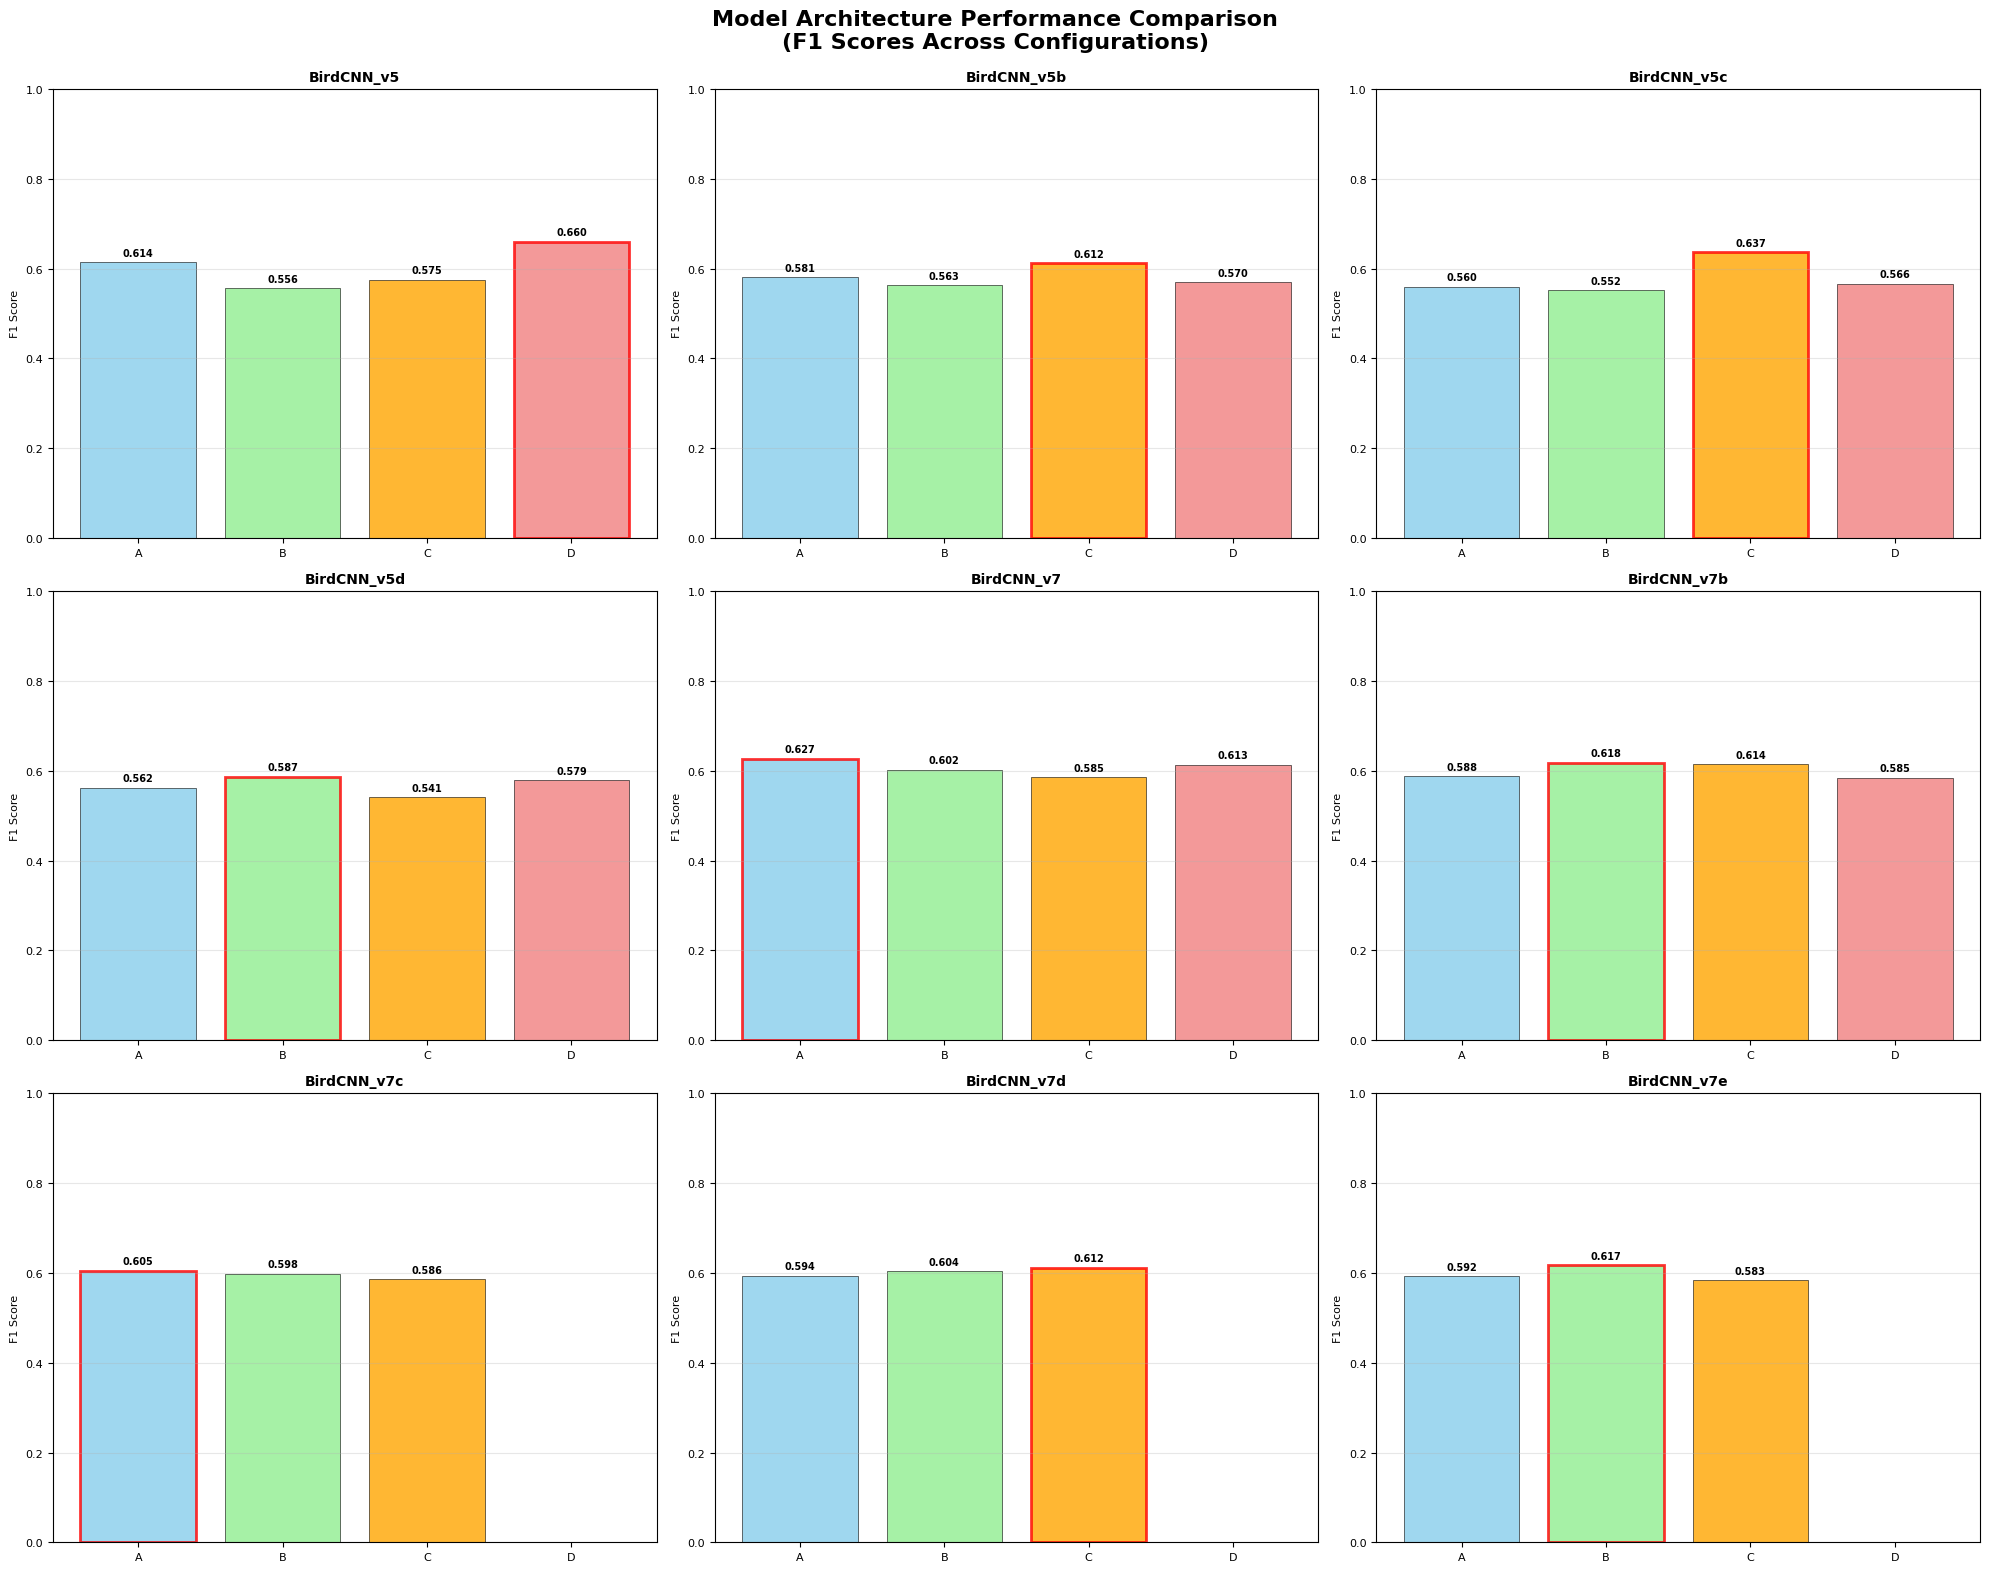

In [16]:
# 4x4 plot grid: F1 scores for each architecture across all configs + highest F1
print("="*80)
print("CREATING ARCHITECTURE COMPARISON PLOTS")
print("="*80)

# Prepare data for plotting
models_f1_data = {}
configs = ['configA', 'configB', 'configC', 'configD']

for model_name in model_architectures.keys():
    models_f1_data[model_name] = {
        'configA': 0,
        'configB': 0, 
        'configC': 0,
        'configD': 0,
        'max_f1': 0
    }
    
    # Extract F1 scores for each config
    for config in configs:
        key = f"{model_name}_{config}"
        if key in building_results and building_results[key]['status'] == 'success':
            f1_score = building_results[key]['result'].get('best_val_f1', 0)
            models_f1_data[model_name][config] = f1_score
    
    # Calculate max F1 across all configs
    config_f1s = [models_f1_data[model_name][config] for config in configs]
    models_f1_data[model_name]['max_f1'] = max(config_f1s)

# Create 4x4 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Model Architecture Performance Comparison\n(F1 Scores Across Configurations)', 
            fontsize=16, fontweight='bold')

model_names = list(model_architectures.keys())

for i, model_name in enumerate(model_names):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Data for this model
    data = models_f1_data[model_name]
    
    # Create bar plot with 5 bars: 4 configs + max
    categories = ['A', 'B', 'C', 'D']
    values = [data['configA'], data['configB'], data['configC'], data['configD']]
    colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Customize subplot
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=8)
    ax.set_ylim(0, max(1.0, max(values) * 1.1))
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Highlight the best performing config
    if data['max_f1'] > 0:
        best_config_idx = values.index(data['max_f1'])  # Exclude 'Max' from search
        bars[best_config_idx].set_edgecolor('red')
        bars[best_config_idx].set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()